In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [2]:
data_dir = ""
model_name = "vgg"

num_classes = 6

batch_size = 128

num_epochs = 50
feature_extract = True

In [3]:
Tr_Loss = []
Tr_Accuracy = []
Val_Loss = []
Val_Accuracy = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                Tr_Loss.append(epoch_loss)
                Tr_Accuracy.append(epoch_acc)
            else:
                Val_Loss.append(epoch_loss)
                Val_Accuracy.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f} Lr: {}'.format(phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 150
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

image_datasets

Initializing Datasets and Dataloaders...


{'train': Dataset ImageFolder
     Number of datapoints: 14034
     Root location: train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(150, 150), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 3000
     Root location: validation
     StandardTransform
 Transform: Compose(
                Resize(size=150, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(150, 150))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.7)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [9]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

C:\Users\Hassan\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0/49
----------
train Loss: 0.6084 Acc: 0.7803 Lr: 0.01
validation Loss: 0.3298 Acc: 0.8913 Lr: 0.01

Epoch 1/49
----------
train Loss: 0.4725 Acc: 0.8206 Lr: 0.01
validation Loss: 0.3157 Acc: 0.8930 Lr: 0.01

Epoch 2/49
----------
train Loss: 0.4586 Acc: 0.8270 Lr: 0.01
validation Loss: 0.3191 Acc: 0.8863 Lr: 0.01

Epoch 3/49
----------
train Loss: 0.4463 Acc: 0.8296 Lr: 0.01
validation Loss: 0.2962 Acc: 0.9003 Lr: 0.01

Epoch 4/49
----------
train Loss: 0.4436 Acc: 0.8335 Lr: 0.01
validation Loss: 0.2899 Acc: 0.9003 Lr: 0.01

Epoch 5/49
----------
train Loss: 0.4425 Acc: 0.8321 Lr: 0.01
validation Loss: 0.2958 Acc: 0.8980 Lr: 0.01

Epoch 6/49
----------
train Loss: 0.4317 Acc: 0.8360 Lr: 0.01
validation Loss: 0.2881 Acc: 0.9020 Lr: 0.01

Epoch 7/49
----------
train Loss: 0.4287 Acc: 0.8349 Lr: 0.01
validation Loss: 0.2959 Acc: 0.8943 Lr: 0.01

Epoch 8/49
----------
train Loss: 0.4319 Acc: 0.8359 Lr: 0.01
validation Loss: 0.2815 Acc: 0.9053 Lr: 0.01

Epoch 9/49
----------
train 

TypeError: cannot unpack non-iterable NoneType object

In [10]:
Path = "VGG16_Aug_AdaptiveLearningRate.pth"
torch.save(model_ft.state_dict(), Path)

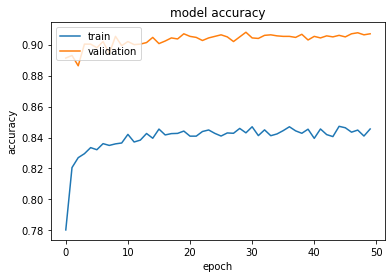

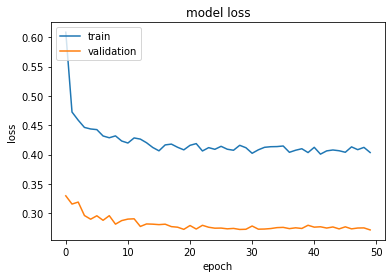

In [19]:
#Accuracy
plt.plot(Tr_Accuracy)
plt.plot(Val_Accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Loss
plt.plot(Tr_Loss)
plt.plot(Val_Loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
model = model_ft.load_state_dict(torch.load("VGG16_Aug_AdaptiveLearningRate.pth"))
model = model_ft.eval().to(device)

In [12]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [13]:
def get_predictions(model, Loader):
    A_Preds = torch.tensor([]).to(device = device)
    
    for batch in Loader:
        images, labels = batch

        images = images.to(device = device)
        labels = labels.to(device = device)
     
        pred = model(images)
        A_Preds = torch.cat((A_Preds, pred), dim = 0)
        
        return A_Preds

In [14]:
Test_Dataset = datasets.ImageFolder('test/', transform)

In [15]:
Pred_Loader = torch.utils.data.DataLoader(Test_Dataset, batch_size = 10, shuffle=True)

In [16]:
def get_num_correct (preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [23]:
classes = 'buildings','forest','glacier','mountains','sea','street'

In [18]:
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long).to(device)
lbllist=torch.zeros(0,dtype=torch.long).to(device)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(Pred_Loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs).to(device)
        _, preds = torch.max(outputs, 1)

        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

conf_mat = confusion_matrix(lbllist.cpu().data.numpy(), predlist.cpu().data.numpy())

class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

print(conf_mat)

[[ 984    9    2    5   22  122]
 [   2 1139    2    9    4   10]
 [   3    9 1049  199   63    7]
 [   2   19  160 1007  105    4]
 [  11    5   48   75  976   13]
 [ 127   19    8   10   30 1042]]


In [20]:
from PIL import Image

filename = ("test/forest/22.jpg")
input_image = Image.open(filename)

In [21]:
preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

input_tensor = preprocess(input_image).to(device)
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 150, 150])

tensor([1.0408e-03, 9.9692e-01, 2.3103e-05, 1.6900e-04, 9.0739e-05, 1.7560e-03],
       device='cuda:0')
tensor(1, device='cuda:0')
forest


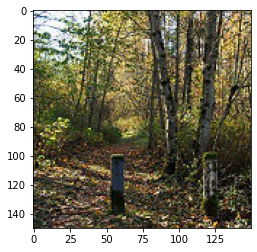

In [24]:
with torch.no_grad():
    output = model(input_batch)

per = torch.nn.functional.softmax(output[0], dim=0)
index = torch.argmax(per, dim = 0)

plt.imshow(input_image)
print(per)
print(index)
print(classes[index])